# Assignment 3 - Policy Gradient Methods
## Special Topics: Reinforcement Learning KV
### WS 2018

<div class="alert alert-info">
    
In this assignment we will solve the Cartpole balancing problem using
the **Policy Gradient Method REINFORCE**.
<br>

In particular we will use a neural network to approximate our policy $\pi(a|s)$. To that end we will rely on an auto-differentiation framwork which will provide us with the gradients of our policy with respect to its parameters.
We will leave it up to you which framework you choose (Theano, Tensorflow, PyTorch, ..), but we of course woun't be able to provide "support" for all of them.

<br>
</div>

---

## Python Imports

- Please make sure that you have installed OpenAI gym (https://gym.openai.com/docs/). This should be anyways ready from your previous assignment.

In [1]:
from __future__ import print_function

import sys
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set some colors for plots
cmap = ['m', 'b', 'g', 'k', 'orange', 'c']

# we also fix a seed for reproducing our results
np.random.seed(4711)

In [2]:
# pytorch imports
# (if you don't want to use PyTorch just replace this with whatever you need)
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F

## Implement Reinforce
In this part of the assignment we will first define the neural network approximating our policy.<br>
In the second part we implement the **REINFORCE** algorithm shown in our class.

### Define Policy Network (2 Points)
Define the policy network. The output of this network is the action selection probability for each of the actions (this will require a *softmax* nonlinearity in the output layer).
You can look in the **function_approximation.ipynb** to re-check how you can define a Neural Network in PyTorch.

<div class="alert alert-info">

**Hint:** We solved the task using a neural network with two hidden layers (each 32 units) and tanh nonlinearity. But the architecture design is up to you.
We actually encourage you to play around with it and investigate its impact on the overall performance of the system.
</div>

<div class="alert alert-info">

**Hint:** Make sure to initialize the weights of your neural network properly.
Possible options for initializing your *[Linear](https://pytorch.org/docs/stable/nn.html#linear)* layer can be found [here](https://pytorch.org/docs/stable/nn.html#torch-nn-init).

We recommend to initialize the weights with *nn.init.xavier_uniform_* and the bias with zeros (nn.init.constant_).
However, we again encourage you to play around with this.

</div>

In [5]:
class Policy(nn.Module):
    """
    Policy network
    """
    def __init__(self, n_inputs=4, n_actions=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=0)
        return x
    
class StateValue(nn.Module):
    """
    State value network; models the expected future reward from a given state
    """
    def __init__(self, n_inputs=4):
        super(StateValue, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)  # Only one output: state value

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

def weights_init(m):
    """
    Initialize the parameters of the network.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, gain=1)
        nn.init.constant_(m.bias.data, 0)

### Reinforce (8 Points)
Implement an agent which learns by the REINFORCE algorithm ... <br>

<div class="alert alert-info"> 

**Hints:**
- Use the Adam update rule with a learning rate of $0.001$ for Stochastic Gradient Ascent.<br>
- Use discounting for computing the returns $G_t$
</div>

In [10]:
class Reinforce(object):
    """
    REINFORCE Agent
    """

    def __init__(self, env, alpha=0.001, use_baseline=False):
        """
        Constructor

        @env: OpenAI gym environment the agent should interact with
        @alpha (float): learning rate of policy optimizer
        """
        self.env = env
        self.alpha = alpha
        self.use_baseline = use_baseline
        self.model = None
        self.value_func = None
        self.reset()

    def reset(self):
        """
        Reset agent:
            - instantiate policy network
            - initialize the parameters of the network
            - instantiate policy optimizer (e.g. optim.Adam)
        """
        self.model = Policy(n_inputs=env.observation_space.shape[0],
                         n_actions=env.action_space.n)
        self.model_optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        self.model.apply(weights_init)
        self.model_optimizer.zero_grad()
        if self.use_baseline:
            #  Initialize also state value model and its optimizer
            lr = self.alpha * 0.1  # Use 10% of policy learning rate
            self.value_func = StateValue(n_inputs=env.observation_space.shape[0])
            self.value_func.apply(weights_init)
            self.value_func_optimizer = optim.Adam(self.value_func.parameters(), lr=lr)
            self.value_func_optimizer.zero_grad()

    def choose_action(self, state):
        """
        Select action given a certain state:
            - compute output of policy network (softmax)
            - sample from network output
            - compute action index

        Returns:
            @action (integer): index of selected action
        """
        output = self.model(torch.from_numpy(state).float())
        action_dist = Categorical(output)
        return action_dist.sample()  # Take one sample (action) from action distribution
    
    def compute_state_value(self, state):
        """
        Returns the current state value of the given state using a network approximation
        """
        value = self.value_func(torch.from_numpy(state).float())
        return value.item()

    def update(self, states, actions, rewards, gamma=0.95):
        """
        Update parameters of agent
        (in particular the parameters of the policy network)

        Inputs (has to match the function "generate_episode"):
            @states (float array): trajectory of observed states
            @actions (int array): vector of selected actions
            @rewards (float array): trajectory of received rewards
            @gamma (float): discounting rate
        """
        G = 0
        returns = []
        t = 0
        i = len(states) - 1
        # Compute discounted returns on each step of episode
        for reward in reversed(rewards):
            v = 0.0  # state value (0 by default i.e. we are not using a baseline)
            if self.use_baseline:
                v = self.compute_state_value(states[i])
                i -= 1
            G = reward + gamma * (G - v)
            returns.insert(0, G)  # Push at the beginning to preserve temporal order
        while t < len(states):
            state = states[t]
            action = actions[t]
            G = returns[t]
            action_probs = self.model(torch.from_numpy(state).float())
            action_dist = Categorical(action_probs)
            loss = -action_dist.log_prob(action) * G  # Negative log-likelihood
            self.model_optimizer.zero_grad()
            # Compute gradients
            loss.backward()
            # Apply gradients
            self.model_optimizer.step()
            if self.use_baseline:
                self.value_func_optimizer.step()
            t += 1

## Generate one Episode (4 Points)
This function should generate a full episode following the agent's policy $\pi$.

In [11]:
def generate_episode(env, agent, max_steps, render=False):
    """
    Generates one episode (S0, A0, R1, ..., RT) on a given
    environment following the agent's policy.

    Inputs:
        @env (OpenAI Gym environment): the environment to interact with
        @agent (as defined above): the agent (policy) to follow
        @max_steps (integer): maximum number of steps in episode.
        @render (boolean): render environment after each action.

    Returns:
        @states (float array): trajectory of observed states
        @actions (int array): vector of selected actions
        @rewards (float array): trajectory of received rewards
        @total_reward (numerical): total accumulated reward of episode
    """
    states = []
    actions = []
    rewards = []
    total_reward = 0
    state = env.reset()
    for t in range(max_steps):
        if render:
            env.render()
        states.append(state)
        action = agent.choose_action(state)
        actions.append(action)
        state, reward, is_final, _ = env.step(action.item())
        total_reward += reward
        rewards.append(reward)
        if is_final:
            break
    return states, actions, rewards, total_reward

## Run Experiment (3 Points)
This function runs one experiment and returns an array containing the reward achieved within each episode.

In [12]:
def run_experiment(env, agent, max_episodes=300, max_steps=200):
    """
    Runs one experiment with given agent on given environment for a certain number of episodes.

    Inputs:
        @env (OpenAI Gym environment): the environment to interact with
        @agent (as defined above): the agent (policy) to follow
        @max_episodes (integer): maximum number of episodes to train on.
        @max_steps (integer): maximum number of steps in episode.

    Returns:
        @rewards (vector with length <max_episodes>): containing the total rewards per episode
    """
    total_rewards = []
    agent.reset()
    for i in range(max_episodes):
        # Generate full episode since REINFORCE needs the complete return
        states, actions, rewards, total_reward = generate_episode(env, agent, max_steps)
        # Update agent parameters with data from episode
        agent.update(states, actions, rewards)
        total_rewards.append(total_reward)
    return total_rewards

## Train
This is the part where we actually train our agent. Make sure that your code allows to re-run the same experiment a couple of times. We will need this in the next part of the assignment.

<div class="alert alert-info">

**Hint:** If you do not manage to implement REINFORCE with baseline just comment the respective lines in the code below to make sure the notebook is executable.

</div>

In [24]:
verbose = False
max_steps = 200         # maximum time steps per episode
max_episodes = 100      # overall maximum number of episodes
num_experiments = 5     # number of experimental re-runs

# init book keeping of rewards
rewards = np.zeros((num_experiments, max_episodes))
rewards_bl = np.zeros((num_experiments, max_episodes))

# select gym environment
env = gym.make('CartPole-v0')

# get action space
n_actions = env.action_space.n
print("Action Space:", n_actions, env.action_space.__class__)

print(env.observation_space)

# get dimensions of observations
in_shape = list(env.observation_space.shape)[0]
print("Observation Space:", in_shape)

# run multiple experiments to get reliable performance estimates
for exp in range(num_experiments):
    print('Experiment run %d' % (exp + 1))

    # Reinforce agent
    agent = Reinforce(env, alpha=0.001)
    
    # Reinforce with baseline agent
    agent_bl = Reinforce(env, alpha=0.001, use_baseline=True)

    # run experiments
    rewards[exp, ] = run_experiment(env, agent, max_episodes, max_steps)
    rewards_bl[exp, ] = run_experiment(env, agent_bl, max_episodes, max_steps)

Action Space: 2 <class 'gym.spaces.discrete.Discrete'>
Box(4,)
Observation Space: 4
Experiment run 1
Experiment run 2
Experiment run 3
Experiment run 4
Experiment run 5


## Visualize the performance of your agent (3 Points)
In order to visualize the performance of your agent **re-train it for 5 times** and keep the reward per episode for each of these runs.
<br>
To be clear:
Run each of the five experiment for a maximum of 200 episodes. What you should end up with is a reward-matrix with shape (5 x 200).
<br><br>
Visualize this reward-matrix via the provided **tsplot** showing the mean and standard deviation of your collected rewards.
<br>

<div class="alert alert-info">

**Remarks:**

- set the limits of your y-axis to [0, 220] to produce comparable plots (ore better plot compare everything in one figure).
- use legends or appropriate titles in your figures
- put labels to x and y axis

</div>

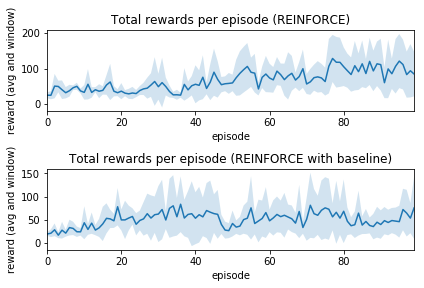

In [25]:
def tsplot(data, label=None, ax=None, **kw):
    """
    Just a helper function for nice std-plots.
    """
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x, cis[0], cis[1], alpha=0.2, **kw)
    ax.plot(x, est, label=label, **kw)
    ax.set_title(label)
    ax.set_xlabel("episode")
    ax.set_ylabel("reward (avg and window)")
    ax.margins(x=0)

fig, (ax1, ax2) = plt.subplots(2,1)
tsplot(rewards, label="Total rewards per episode (REINFORCE)", ax=ax1)
tsplot(rewards_bl, label="Total rewards per episode (REINFORCE with baseline)", ax=ax2)
plt.tight_layout()
plt.show()

### Comment

We can appreciate how in both cases the average total reward per episode improves after a number of training episodes, from a starting average of ~25 to a final average of ~100. However, REINFORCE with baseline does not perform very well, which is probably due to a wrong selection of hyperparameters (e.g learning rate, step size) or a poor approximation of the value function. We should therefore try with different networks and hyperparameters in order to hopefully improve these results.

# REINFORCE with Baseline (5 Points)
Implement **REINFORCE with Baseline**.

- You can either create a new class or include the implementation in the REINFORCE class above (Recall REINFORCE is a special case of REINFORCE with Baseline).
- Run your implementation and compare *REINFORCE* and *REINFORCE with Baseline* in the experiments above.

**Hints**:
- Don't forget to discount your rewards when trying to learn a value function (see lecture slides)
- If it does not work out of the box, don't get frustrated. It is not that easy to get the balance between the two different learning rates for the policy- and the value-network right. Grid search / Random search is your friend
- Don't share the network parameters for policy and value network for this example. Use individual networks for each of them
- Make sure the output of your value network is linear (e.g.: don't use a non-linearity)
- If learning is unstable you can try to use a smaller learning rate for optimizing the value network (e.g. 10 times smaller than the policy learning rate)

In [26]:
# Implemented in the REINFORCE class when use_baseline=True

# Visual Inspection (0 Points, $\infty$ fun)

<div class="alert alert-info">

Once you are done with training your agents you can visually inspect their behavior of your agent by calling the function *env.render()* after each step.
</div>

In [9]:
import time
env = gym.make('CartPole-v0')

for i_episode in range(5):
    observation = env.reset()
    for t in range(200):
        env.render()
        time.sleep(0.02)
        
        # TODO: replace this with your trained agent for action selection.
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        
        if done:
            break